# Atmospheric composition distribution by CAMS and GOME-2

### Main goal:
* Compare GOME-2 and CAMS datasets for NO<sub>2</sub>, O<sub>3</sub> and HCHO (Level 2).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import wget # Important for GOME-2
import subprocess # Important for GOME-2
import bs4 # Important for GOME-2 L2
import h5py # Important for GOME-2 L2
import geocoder
import seaborn as sns

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_gome.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
component_nom = 'HCHO'

sensor = 'gome'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']

model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = -20
lon_max = 40
lat_min = 30
lat_max = 70 

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2021-09-01'
end_date = '2021-09-02'
dates = search_period(start_date, end_date)

SEARCH PERIOD
- In days: ('2021-09-01', '2021-09-02')


## 2. Model data

### Download, read and subset data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds = subset(model_ds, bbox)
model_ds

2021-09-16 17:33:08,163 INFO Welcome to the CDS
2021-09-16 17:33:08,163 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-09-16 17:33:08,179 INFO Request is queued


The file does not exist, it will be downloaded.


2021-09-16 17:33:09,187 INFO Request is running
2021-09-16 17:33:10,696 INFO Request is completed
2021-09-16 17:33:10,698 INFO Downloading https://download-0002.copernicus-atmosphere.eu/cache-compute-0002/cache/data5/adaptor.mars_constrained.internal-1631813590.193289-19909-6-34d48554-93bc-4f5e-87a2-8ade0776d7ac.grib to data/cams/HCHO/HCHO-hourly-tc-2021-09-01-2021-09-02.grib (9.3M)
2021-09-16 17:33:10,877 INFO Download rate 51.9M/s


<xarray.Dataset>
Dimensions:     (latitude: 101, longitude: 151, step: 4, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-09-01 2021-09-02
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.4 30.8 31.2 ... 68.8 69.2 69.6 70.0
  * longitude   (longitude) float64 -20.0 -19.6 -19.2 -18.8 ... 39.2 39.6 40.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-16T17:33 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [7]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Collect and read data as xarray

In [8]:
sensor_product_names = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

--2021-09-16 17:33:11--  ftp://acsaf.eoc.dlr.de/gome2a/offline/2021/09/01/
           => '.listing'
Resolving acsaf.eoc.dlr.de (acsaf.eoc.dlr.de)... 129.247.254.12
Connecting to acsaf.eoc.dlr.de (acsaf.eoc.dlr.de)|129.247.254.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gome2a/offline/2021/09/01 ... done.
==> PASV ... done.    ==> LIST ... done.

     0K ..                                                     77.9K=0.03s

2021-09-16 17:33:12 (77.9 KB/s) - '.listing' saved [2155]

Removed '.listing'.
Wrote HTML-ized index to 'data/gome/HCHO/index.html'.
No URLs found in ftp://acsaf.eoc.dlr.de/gome2a/offline/2021/09/01/.
--2021-09-16 17:33:12--  ftp://acsaf.eoc.dlr.de/gome2a/offline/2021/09/01/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20210901013613_051_METOPA_77149_DLR_04.HDF5
           => 'data/gome/HCHO/2021-09-01/A/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20210901013613_051_METOPA_77149_DLR_04.HD

In [9]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, component_nom, satellites)
sensor_ds

/tmp/ipykernel_1808339/3379296890.py:55: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts
/tmp/ipykernel_1808339/3379296890.py:55: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.Dataset>
Dimensions:    (latitude: 360, longitude: 720, time: 2)
Coordinates:
  * latitude   (latitude) float64 -74.76 -74.3 -73.84 ... 87.87 88.78 88.79
  * longitude  (longitude) float64 -180.0 -180.0 -179.0 ... 178.0 179.0 179.0
  * time       (time) datetime64[ns] 2021-09-01 2021-09-02
Data variables:
    HCHOtotal  (time, latitude, longitude) float64 nan nan nan ... -1.0 nan nan

## 4. Match data (and apply averaging kernels)

In [10]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column)
match_table

FOR EST. TIME: 2021-09-01T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR EST. TIME: 2021-09-02T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.


,latitude,longitude,time,HCHOtotal,delta_time,step_index,model_column
0,30.312491,-20.000193,2021-09-01,NaN,2021-09-01 12:00:00,2,2.822243e+15
1,30.312491,-19.001360,2021-09-01,NaN,2021-09-01 12:00:00,2,2.899148e+15
2,30.312491,-19.000195,2021-09-01,NaN,2021-09-01 12:00:00,2,2.899148e+15
3,30.312491,-18.001370,2021-09-01,NaN,2021-09-01 12:00:00,2,2.993036e+15
4,30.312491,-18.000197,2021-09-01,NaN,2021-09-01 12:00:00,2,2.993036e+15
...,...,...,...,...,...,...,...
10643,69.652069,37.999703,2021-09-02,NaN,2021-09-02 12:00:00,2,8.524234e+14
10644,69.652069,38.998040,2021-09-02,NaN,2021-09-02 12:00:00,2,8.548125e+14
10645,69.652069,38.999702,2021-09-02,NaN,2021-09-02 12:00:00,2,8.548125e+14
10646,69.652069,39.998030,2021-09-02,NaN,2021-09-02 12:00:00,2,8.693845e+14


## 5. Merge data and calculate difference

In [11]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

HCHOtotal  step_index  model_column  \
latitude  longitude  time                                                 
30.312491 -20.000193 2021-09-01           NaN           2  2.822243e+15   
                     2021-09-02  3.517246e+15           2  2.858057e+15   
          -19.001360 2021-09-01           NaN           2  2.899148e+15   
                     2021-09-02           NaN           2  2.825182e+15   
          -19.000195 2021-09-01           NaN           2  2.899148e+15   
...                                       ...         ...           ...   
69.652069  38.999702 2021-09-02           NaN           2  8.548125e+14   
           39.998030 2021-09-01  1.755406e+15           2  1.095034e+15   
                     2021-09-02           NaN           2  8.693845e+14   
           39.999700 2021-09-01           NaN           2  1.095034e+15   
                     2021-09-02           NaN           2  8.693845e+14   

                                   difference  
latitude  longitude  time                      
30.312491 -20.000193 2021-09-01           NaN  
                     2021-09-02  6.591884e+14  
          -19.001360 2021-09-01           NaN  
                     2021-09-02           NaN  
          -19.000195 2021-09-01           NaN  
...                                       ...  
69.652069  38.999702 2021-09-02           NaN  
           39.998030 2021-09-01  6.603724e+14  
                     2021-09-02           NaN  
           39.999700 2021-09-01           NaN  
                     2021-09-02           NaN  

[21296 rows x 4 columns]

In [12]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,HCHOtotal,step_index,model_column,difference
count,5.107000e+03,21296.0,2.129600e+04,5.107000e+03
mean,2.565174e+15,2.0,3.369844e+15,-7.655205e+14
std,4.839005e+15,0.0,1.651693e+15,4.632992e+15
min,-1.709735e+16,2.0,5.507456e+14,-2.424267e+16
25%,-1.000000e+00,2.0,1.905766e+15,-3.311266e+15
50%,4.849600e+14,2.0,3.212689e+15,-1.495089e+15
75%,4.926438e+15,2.0,4.612312e+15,1.393027e+15
max,5.804306e+16,2.0,9.975257e+15,5.663797e+16


## 6. Show comparison plots

### Select plot dates

In [13]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-09' '2021-09']


### Select plot extent

In [14]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-20, 30), (40, 70))


### Compare CAMS and GOME-2 total columns

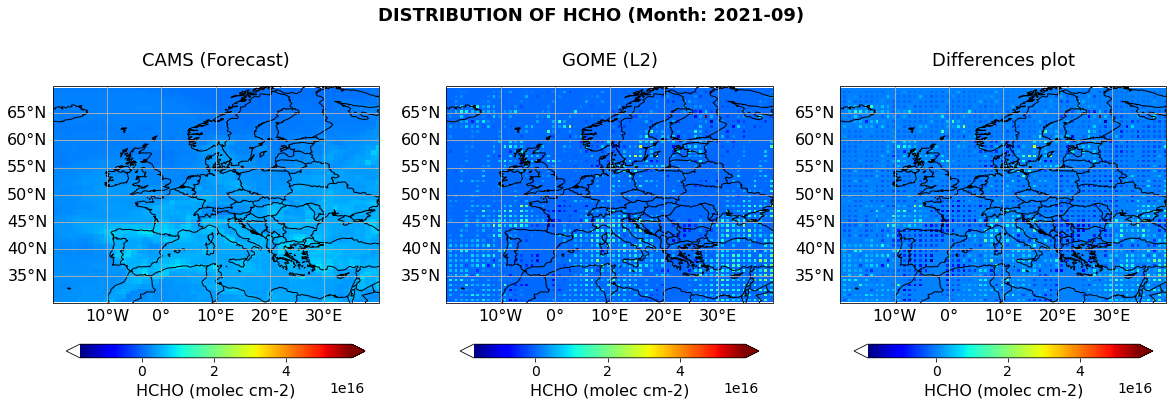

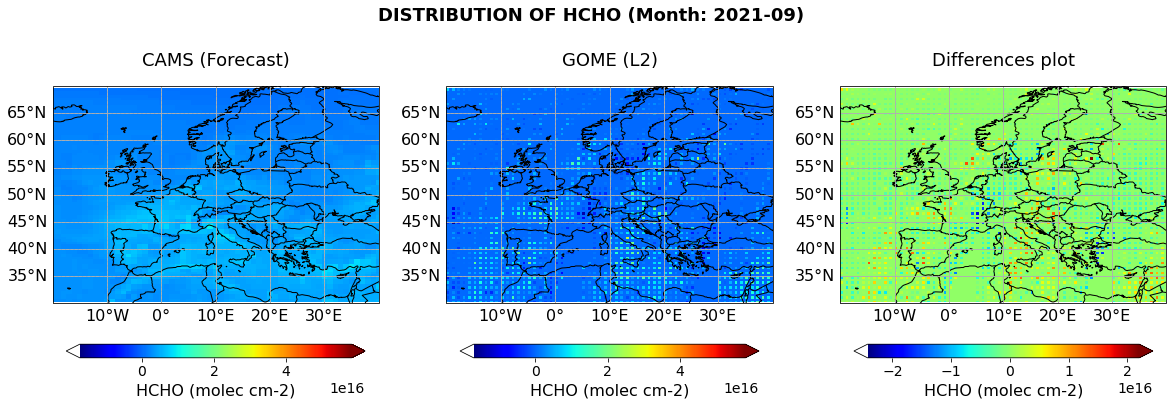

In [15]:
range_type = 'equal' # original, positive or equal
distribution_type = 'individual' # aggregated or individual

projection = ccrs.PlateCarree()
color_scale = 'jet'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.10, 
                          model_type, sensor_type, range_type, sensor_column, distribution_type, projection, 
                          color_scale)

## 7. Retrieve nearest values to specific latitude and longitude

In [23]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
coords_search = pairwise(coords_search_list)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all

HCHOtotal  \
lat_search lon_search latitude  longitude time                       
50         60         49.608444 39.998030 2021-09-01  5.858417e+15   
                      50.412462 39.999700 2021-09-02 -1.000000e+00   
4          10         30.475893 9.998340  2021-09-01  2.822298e+14   
                      30.312491 9.999753  2021-09-02  5.718282e+15   
20         30         30.475893 29.998133 2021-09-01  1.262786e+16   
                      30.312491 29.999718 2021-09-02  8.908355e+14   

                                                      step_index  \
lat_search lon_search latitude  longitude time                     
50         60         49.608444 39.998030 2021-09-01           2   
                      50.412462 39.999700 2021-09-02           2   
4          10         30.475893 9.998340  2021-09-01           2   
                      30.312491 9.999753  2021-09-02           2   
20         30         30.475893 29.998133 2021-09-01           2   
                      30.312491 29.999718 2021-09-02           2   

                                                      model_column  \
lat_search lon_search latitude  longitude time                       
50         60         49.608444 39.998030 2021-09-01  4.423269e+15   
                      50.412462 39.999700 2021-09-02  4.969032e+15   
4          10         30.475893 9.998340  2021-09-01  3.458594e+15   
                      30.312491 9.999753  2021-09-02  3.556381e+15   
20         30         30.475893 29.998133 2021-09-01  6.288874e+15   
                      30.312491 29.999718 2021-09-02  6.469262e+15   

                                                        difference  
lat_search lon_search latitude  longitude time                      
50         60         49.608444 39.998030 2021-09-01  1.435148e+15  
                      50.412462 39.999700 2021-09-02 -4.969032e+15  
4          10         30.475893 9.998340  2021-09-01 -3.176365e+15  
                      30.312491 9.999753  2021-09-02  2.161902e+15  
20         30         30.475893 29.998133 2021-09-01  6.338988e+15  
                      30.312491 29.999718 2021-09-02 -5.578427e+15

## 8. Scatter plots by bbox

Fit equation: HCHO_model = HCHO_sensor * 0.10 + (3.08E+15)
Coefficient of determination (R2): 0.09


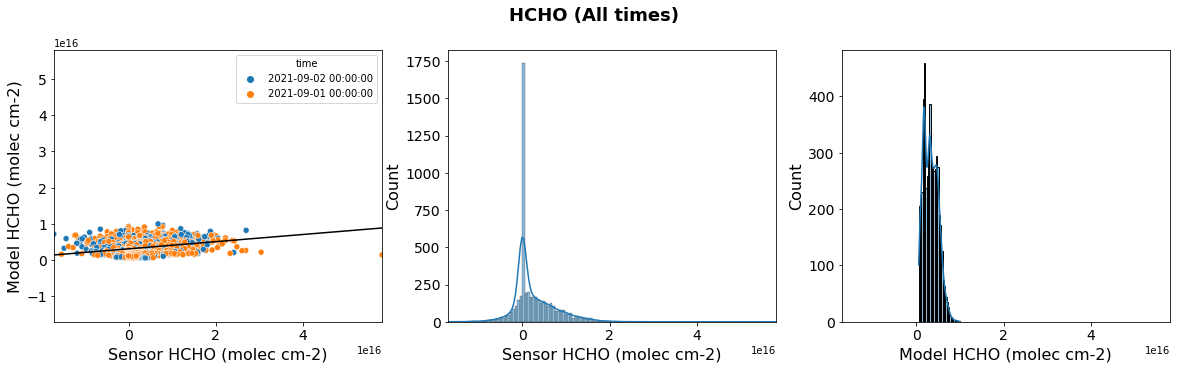

In [17]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [18]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2021-09-01T00:00:00.000000000, 2021-09-02T00:...","((-20, 30), (40, 70))",0.085546,0.0993,3.075973e+15


## 9. Scatter plots by season

Fit equation: HCHO_model = HCHO_sensor * 0.10 + (3.08E+15)
Coefficient of determination (R2): 0.09


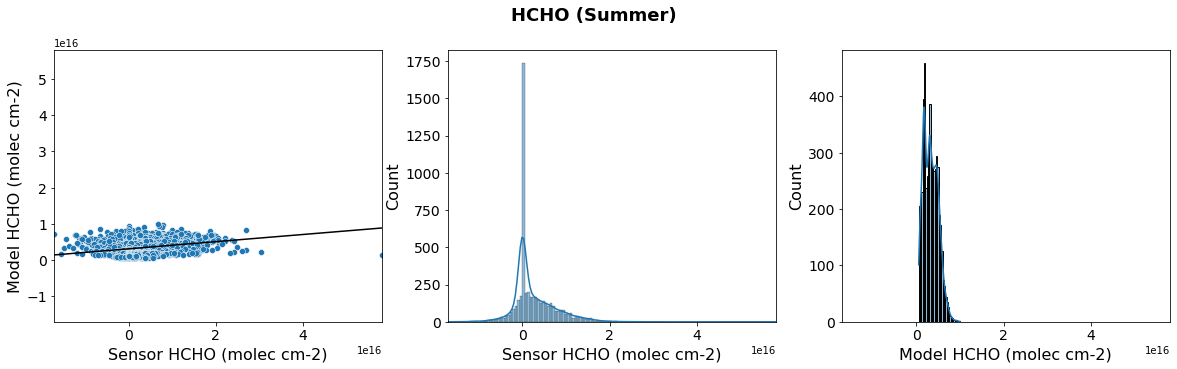

In [19]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [20]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Summer,"((-20, 30), (40, 70))",0.085546,0.0993,3.075973e+15


## 10. Scatter plots by country (Google API required!)

In [21]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, \n                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)\n"

In [22]:
#summary